In [1]:
from copy import deepcopy
from ord_schema.proto import reaction_pb2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ord_diff.evaluation import BatchEvaluator, get_compounds, PairEvaluator
from ord_diff.schema import MDictListDiff, MessageType
from ord_diff.utils import json_load

# reformat the imports
from sklearn.metrics import (
    cohen_kappa_score,
    matthews_corrcoef,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    multilabel_confusion_matrix,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

In [2]:
# load batch evaluator
batch_evaluator = json_load("workplace_eval/202311060037/batch_evaluator.json.gz")
batch_evaluator = BatchEvaluator(**batch_evaluator)
pair_evaluators = batch_evaluator.pair_evaluators

print(f"number of reactions in batch evaluator: {len(pair_evaluators)}")

number of reactions in batch evaluator: 10000


In [3]:
# checking the numbers only for now

# only the reaction inputs for now
# Removal,
# Alteration
# Intact


# when there are compounds missing
distances_list_case1 = []
reaction_roles_ref_list_case1 = []
reaction_roles_inf_list_case1 = []
case1_counter = 0

# when there are no compounds missing, but reaction role is missing
distances_list_case2 = []
reaction_roles_ref_list_case2 = []
reaction_roles_inf_list_case2 = []
case2_counter = 0

# when there are no compounds missing, and the reaction role is not missing
distances_list_case3 = []
reaction_roles_ref_list_case3 = []
reaction_roles_inf_list_case3 = []
case3_counter = 0


infered_compounds_missing_counter = 0
workups_counter = 0
ref_counter = 0

for pe in pair_evaluators:
    ref_compounds = get_compounds(pe.reaction_message_ref, extracted_from="inputs")

    # can have ValueError for pe.reaction_message_inf because infered compounds are missing
    try:
        inf_compounds = get_compounds(pe.reaction_message_inf, extracted_from="inputs")
    except:
        # infered_compounds_missing_counter += 1
        continue

    text = pe.parsed_model_output.instruction
    compoud_list_diff = MDictListDiff.from_message_list_pair(
        ref_compounds, inf_compounds, MessageType.COMPOUND, text, text
    )

    # when there are missing compounds
    if compoud_list_diff.n_absent > 0:
        pair_comparisons = compoud_list_diff.pair_comparisons
        for compound_diff in pair_comparisons:
            # print(f"distance: {compound_diff.deep_distance}")

            if compound_diff is None:
                infered_compounds_missing_counter += 1
                continue

            reaction_role_ref = compound_diff.md1.d.get("reactionRole")
            reaction_role_inf = compound_diff.md2.d.get("reactionRole")

            # not counting the WORKUP
            if "WORKUP" not in [reaction_role_ref, reaction_role_inf]:
                reaction_roles_inf_list_case1.append(reaction_role_inf)
                reaction_roles_ref_list_case1.append(reaction_role_ref)
                case1_counter += 1
                distances_list_case1.append(compound_diff.deep_distance)
            else:
                workups_counter += 1

    # when no compounds missing
    else:
        for compound_diff in compoud_list_diff.pair_comparisons:
            reaction_role_ref = compound_diff.md1.d.get("reactionRole")
            reaction_role_inf = compound_diff.md2.d.get("reactionRole")

            # when there are no compounds missing, but reaction role is missing
            if reaction_role_inf is None:
                reaction_roles_inf_list_case2.append("missing")
                reaction_roles_ref_list_case2.append(reaction_role_ref)
                case2_counter += 1
                distances_list_case2.append(compound_diff.deep_distance)
            # when there are no compounds missing, and the reaction role is present
            else:
                # not counting the WORKUP
                if "WORKUP" not in [reaction_role_ref, reaction_role_inf]:
                    reaction_roles_inf_list_case3.append(reaction_role_inf)
                    reaction_roles_ref_list_case3.append(reaction_role_ref)
                    distances_list_case3.append(compound_diff.deep_distance)
                    case3_counter += 1
                    # when there are compounds missing, but the reaction role is missing
                else:
                    workups_counter += 1

In [4]:
print(f"workups_counter: {workups_counter}")
print(f"infered_compounds_missing_counter: {infered_compounds_missing_counter}")
print(f"case1_counter: {case1_counter}")
print(f"case2_counter: {case2_counter}")
print(f"case3_counter: {case3_counter}")
print(
    f"total: {case1_counter + case2_counter + case3_counter + infered_compounds_missing_counter + workups_counter}"
)

workups_counter: 1
infered_compounds_missing_counter: 945
case1_counter: 2835
case2_counter: 1
case3_counter: 26656
total: 30438


In [5]:
print(f"len(distances_list_case1): {len(distances_list_case1)}")
print(f"len(distances_list_case2): {len(distances_list_case2)}")
print(f"len(distances_list_case3): {len(distances_list_case3)}")

len(distances_list_case1): 2835
len(distances_list_case2): 1
len(distances_list_case3): 26656


## Two subplots in one figure


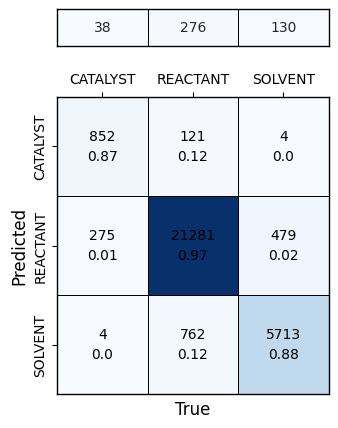

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.gridspec import GridSpec

# df_missing = pd.DataFrame(
#     {
#         "SOLVENT": 130,
#         "REACTANT": 276,
#         "CATALYST": 38,
#     },
#     index=[0],
# )
df_missing = pd.DataFrame(
    index=["CATALYST", "REACTANT", "SOLVENT"],
    data=[38, 276, 130],
)


reaction_roles_ref = (
    reaction_roles_ref_list_case1
    + reaction_roles_ref_list_case2
    + reaction_roles_ref_list_case3
)
reaction_roles_inf = (
    reaction_roles_inf_list_case1
    + reaction_roles_inf_list_case2
    + reaction_roles_inf_list_case3
)
labels = np.unique(
    reaction_roles_ref_list_case3
    + reaction_roles_ref_list_case2
    + reaction_roles_ref_list_case1
).tolist()  # + ["missing"]

confusion_arr = confusion_matrix(
    y_true=reaction_roles_ref,
    y_pred=reaction_roles_inf,
    labels=labels,
)

# print(f"labels: {labels}\n\n")
# print(confusion_arr)

df = pd.DataFrame(confusion_arr, index=labels, columns=labels)
df_arr = df.to_numpy()

confusion_arr_norm_true = confusion_matrix(
    y_true=reaction_roles_ref,
    y_pred=reaction_roles_inf,
    labels=labels,
    # normalize{‘true’, ‘pred’, ‘all’}, default=None
    # Normalizes confusion matrix over the true (rows),
    # predicted (columns) conditions or all the population. If None, confusion matrix will not be normalized.
    normalize="pred",
)
df_norm_pred = pd.DataFrame(confusion_arr_norm_true, index=labels, columns=labels)
df_norm_pred_arr = df_norm_pred.to_numpy()


# fig, (ax, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(6, 6))
fig = plt.figure(figsize=(3.5, 5))
gs = GridSpec(9, 1)
ax = fig.add_subplot(gs[2:, 0])

# # Define color maps and normalization
# cmap_left = plt.cm.Blues
# # cmap_left = plt.cm.gist_yarg
# norm_left = Normalize(vmin=np.min(df_arr), vmax=np.max(df_arr))

# # cmap_right = plt.cm.Reds
# # cmap_right = plt.cm.Blues
# cmap_right = plt.cm.gist_yarg
# norm_right = Normalize(vmin=np.min(df_norm_pred_arr), vmax=np.max(df_norm_pred_arr))

cmap_selected = "Blues"
# cmap_selected = "gist_yarg"
vmax = max(np.max(df_arr), np.max(df_missing.to_numpy()))

res = sns.heatmap(
    # df_norm_pred,
    df,
    annot=False,
    ax=ax,
    # fmt=".0f",
    cmap=cmap_selected,
    # cmap="Greys",
    # alpha = 0.08,
    linewidths=0.5,
    linecolor="black",
    vmin=0,
    vmax=vmax,
    cbar=False,
    annot_kws={"fontsize": 10, "color": "black"},
)

# Drawing the frame
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)

# add the value from df_norm_pred as text to the heatmap
for i in range(df_norm_pred_arr.shape[0]):
    for j in range(df_norm_pred_arr.shape[1]):
        # Calculate colors based on values
        # ax.fill(
        #     [j, j + 1, j + 1, j], [i, i, i + 1, i + 1], color=color_right, alpha=0.5
        # )
        ax.text(
            i + 0.5,
            j + 0.6,
            f"{round(df_norm_pred_arr[i, j], 2)}",
            color="black",
            ha="center",
            va="center",
            fontsize=10,
        )
        ax.text(
            i + 0.5,
            j + 0.4,
            f"{df_arr[i, j]}",
            color="black",
            ha="center",
            va="center",
            fontsize=10,
        )

ax.xaxis.tick_top()

# plot the missing compounds row
ax2 = fig.add_subplot(gs[:1, 0])
res2 = sns.heatmap(
    # df_norm_pred,
    df_missing.T,
    annot=True,
    ax=ax2,
    fmt=".0f",
    cmap=cmap_selected,
    # cmap="Greys",
    # alpha = 0.08,
    linewidths=0.5,
    linecolor="black",
    vmin=0,
    vmax=vmax,
    cbar=False,
    # annot_kws={"fontsize": 10, "color": "black"},
)
# Drawing the frame
for _, spine in res2.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)

ax.set_xlabel("True", fontsize=12)
ax.set_ylabel("Predicted", fontsize=12)

# plot the rows in three cells
# ax2.heatmap(df_missing.columns, df_missing.values[0], color="skyblue")

# data = df_missing.T.to_numpy()[::-1]

# for j in range(data.shape[1]):
#     for i in range(data.shape[0]):
#         # Calculate colors based on values
#         # color_left = cmap_left(norm_left(df_arr[i, j]))
#         # color_right = cmap_right(norm_right(data[i, j]))
#         # ax2.fill(
#         #     [j, j + 1, j + 1, j], [i, i, i + 1, i + 1], color=color_right, alpha=0.5
#         # )
#         ax2.text(
#             j + 0.5, i + 0.5, f"{data[i, j]}", color="black", ha="center", va="center"
#         )

# for i, label in enumerate(df_missing.index):
#     ax2.text(
#         -0.65, i + 0.5, label, color="black", ha="center", va="center", fontsize=10
#     )

# ax2.set_xlabel("Missing", fontsize=12)
ax2.set_xticks([])
ax2.set_yticks([])

# hide the outer frame
# ax2.spines["top"].set_visible(False)
# ax2.spines["right"].set_visible(False)
# ax2.spines["left"].set_visible(False)
# ax2.spines["bottom"].set_visible(False)
# ax2.axis("off")

# plt.savefig("workplace_eval/202311060037/confusion_matrix_in_one_Blues_v2.png", dpi=350)
# Show the plot
plt.show()

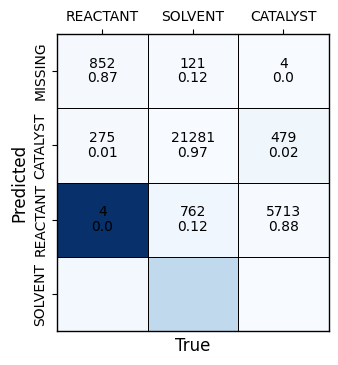

In [28]:
# plot the missing compounds row merged with the heatmap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.gridspec import GridSpec

# df_missing = pd.DataFrame(
#     index=["CATALYST", "REACTANT", "SOLVENT"],
#     data=[38, 276, 130],
# )
df_missing = pd.DataFrame(
    {
        "REACTANT": 276,
        "SOLVENT": 130,
        "CATALYST": 38,
    },
    index=["MISSING"],
)


reaction_roles_ref = (
    reaction_roles_ref_list_case1
    + reaction_roles_ref_list_case2
    + reaction_roles_ref_list_case3
)
reaction_roles_inf = (
    reaction_roles_inf_list_case1
    + reaction_roles_inf_list_case2
    + reaction_roles_inf_list_case3
)
labels = np.unique(
    reaction_roles_ref_list_case3
    + reaction_roles_ref_list_case2
    + reaction_roles_ref_list_case1
).tolist()  # + ["missing"]

confusion_arr = confusion_matrix(
    y_true=reaction_roles_ref,
    y_pred=reaction_roles_inf,
    labels=labels,
)

# print(f"labels: {labels}\n\n")
# print(confusion_arr)

df = pd.DataFrame(confusion_arr, index=labels, columns=labels)
df_arr = df.to_numpy()

df_merged = pd.concat([df_missing, df], axis=0, join="inner")
df_merged_arr = df_merged.to_numpy()

confusion_arr_norm_true = confusion_matrix(
    y_true=reaction_roles_ref,
    y_pred=reaction_roles_inf,
    labels=labels,
    # normalize{‘true’, ‘pred’, ‘all’}, default=None
    # Normalizes confusion matrix over the true (rows),
    # predicted (columns) conditions or all the population. If None, confusion matrix will not be normalized.
    normalize="pred",
)
df_norm_pred = pd.DataFrame(confusion_arr_norm_true, index=labels, columns=labels)
df_norm_pred_arr = df_norm_pred.to_numpy()


# fig, (ax, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(6, 6))
fig = plt.figure(figsize=(3.5, 5))
gs = GridSpec(9, 1)
ax = fig.add_subplot(gs[2:, 0])

cmap_selected = "Blues"
# cmap_selected = "gist_yarg"
vmax = max(np.max(df_arr), np.max(df_missing.to_numpy()))

res = sns.heatmap(
    # df_norm_pred,
    df_merged,
    annot=False,
    ax=ax,
    # fmt=".0f",
    cmap=cmap_selected,
    # cmap="Greys",
    # alpha = 0.08,
    linewidths=0.5,
    linecolor="black",
    vmin=0,
    vmax=vmax,
    cbar=False,
    annot_kws={"fontsize": 10, "color": "black"},
)

# Drawing the frame
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)

# add the value from df_norm_pred as text to the heatmap
for i in range(df_norm_pred_arr.shape[0]):
    for j in range(df_norm_pred_arr.shape[1]):
        # Calculate colors based on values
        # ax.fill(
        #     [j, j + 1, j + 1, j], [i, i, i + 1, i + 1], color=color_right, alpha=0.5
        # )
        ax.text(
            i + 0.5,
            j + 0.6,
            f"{round(df_norm_pred_arr[i, j], 2)}",
            color="black",
            ha="center",
            va="center",
            fontsize=10,
        )
        ax.text(
            i + 0.5,
            j + 0.4,
            f"{df_arr[i, j]}",
            color="black",
            ha="center",
            va="center",
            fontsize=10,
        )

ax.xaxis.tick_top()

# # plot the missing compounds row
# ax2 = fig.add_subplot(gs[:1, 0])
# res2 = sns.heatmap(
#     # df_norm_pred,
#     df_missing.T,
#     annot=True,
#     ax=ax2,
#     fmt=".0f",
#     cmap=cmap_selected,
#     # cmap="Greys",
#     # alpha = 0.08,
#     linewidths=0.5,
#     linecolor="black",
#     vmin=0,
#     vmax=vmax,
#     cbar=False,
#     # annot_kws={"fontsize": 10, "color": "black"},
# )
# # Drawing the frame
# for _, spine in res2.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(1)

ax.set_xlabel("True", fontsize=12)
ax.set_ylabel("Predicted", fontsize=12)


# ax2.set_xlabel("Missing", fontsize=12)
ax2.set_xticks([])
ax2.set_yticks([])


# plt.savefig("workplace_eval/202311060037/confusion_matrix_in_one_Blues_v3.png", dpi=350)
# Show the plot
plt.show()

In [15]:
df_missing

,REACTANT,SOLVENT,CATALYST
0,276,130,38


In [8]:
df_norm_pred

,CATALYST,REACTANT,SOLVENT
CATALYST,0.872057,0.012480,0.000617
REACTANT,0.123849,0.965782,0.117611
SOLVENT,0.004094,0.021738,0.881772


In [25]:
# df

df_missing = pd.DataFrame(
    {
        "REACTANT": 276,
        "SOLVENT": 130,
        "CATALYST": 38,
    },
    index=["MISSING"],
)

# merge df and df_missing together
df_merged = pd.concat([df, df_missing], axis=0, join="inner")
df_merged

,CATALYST,REACTANT,SOLVENT
CATALYST,852,275,4
REACTANT,121,21281,762
SOLVENT,4,479,5713
MISSING,38,276,130


In [23]:
# missing_compounds_reactants_counter: 276
# missing_compounds_products_counter: 0
# missing_compounds_solvents_counter: 130
# missing_compounds_catalysts_counter: 38

df_missing

,REACTANT,SOLVENT,CATALYST
Missing,276,130,38
